* Отсюда алгоритм поиска триплетов https://vk.com/away.php?to=http%3A%2F%2Fwww.machinelearning.ru%2Fwiki%2Fimages%2Fb%2Fb9%2FFeldman18bsc.pdf&cc_key=

In [ ]:
!python -m spacy download ru_core_news_lg

In [ ]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load("ru_core_news_lg")

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 100)
%matplotlib inline

In [ ]:
text = '''Мистер и миссис Дурсль проживали в доме номер четыре по Тисовой улице и всегда с гордостью заявляли, что они, слава богу, абсолютно нормальные люди. Уж от кого-кого, а от них никак нельзя было ожидать, чтобы они попали в какую-нибудь странную или загадочную ситуацию. Мистер и миссис Дурсль весьма неодобрительно относились к любым странностям, загадкам и прочей ерунде.

Мистер Дурсль возглавлял фирму под названием «Граннингс», которая специализировалась на производстве дрелей. Это был полный мужчина с очень пышными усами и очень короткой шеей. Что же касается миссис Дурсль, она была тощей блондинкой с шеей почти вдвое длиннее, чем положено при ее росте. Однако этот недостаток пришелся ей весьма кстати, поскольку большую часть времени миссис Дурсль следила за соседями и подслушивала их разговоры. А с такой шеей, как у нее, было очень удобно заглядывать за чужие заборы. У мистера и миссис Дурсль был маленький сын по имени Дадли, и, по их мнению, он был самым чудесным ребенком на свете.

Семья Дурслей имела все, чего только можно пожелать. Но был у них и один секрет. Причем больше всего на свете они боялись, что кто-нибудь о нем узнает. Дурсли даже представить себе не могли, что с ними будет, если выплывет правда о Поттерах. Миссис Поттер приходилась миссис Дурсль родной сестрой, но они не виделись вот уже несколько лет. Миссис Дурсль даже делала вид, что у нее вовсе нет никакой сестры, потому что сестра и ее никчемный муж были полной противоположностью Дурслям.

Дурсли содрогались при одной мысли о том, что скажут соседи, если на Тисовую улицу пожалуют Поттеры. Дурсли знали, что у Поттеров тоже есть маленький сын, но они никогда его не видели. И они категорически не хотели, чтобы их Дадли общался с ребенком таких родителей.

Когда во вторник мистер и миссис Дурсль проснулись скучным и серым утром — а именно с этого утра начинается наша история, — ничто, включая покрытое тучами небо, не предвещало, что вскоре по всей стране начнут происходить странные и загадочные вещи. Мистер Дурсль что-то напевал себе под нос, завязывая самый отвратительный из своих галстуков. А миссис Дурсль, с трудом усадив сопротивляющегося и орущего Дадли на высокий детский стульчик, со счастливой улыбкой пересказывала мужу последние сплетни.

Никто из них не заметил, как за окном пролетела большая сова-неясыть.

В половине девятого мистер Дурсль взял свой портфель, клюнул миссис Дурсль в щеку и попытался на прощанье поцеловать Дадли, но промахнулся, потому что Дадли впал в ярость, что с ним происходило довольно часто. Он раскачивался взад-вперед на стульчике, ловко выуживал из тарелки кашу и заляпывал ею стены.

— Ух, ты моя крошка, — со смехом выдавил из себя мистер Дурсль, выходя из дома.

Он сел в машину и выехал со двора.

На углу улицы мистер Дурсль заметил, что происходит что-то странное, — на тротуаре стояла кошка и внимательно изучала лежащую перед ней карту. В первую секунду мистер Дурсль даже не понял, что именно он увидел, но затем, уже миновав кошку, затормозил и резко оглянулся. На углу Тисовой улицы действительно стояла полосатая кошка, но никакой карты видно не было.

— И привидится же такое! — буркнул мистер Дурсль.

Наверное, во всем были виноваты мрачное утро и тусклый свет фонаря. На всякий случай мистер Дурсль закрыл глаза, потом открыл их и уставился на кошку. А кошка уставилась на него.

Мистер Дурсль отвернулся и поехал дальше, продолжая следить за кошкой в зеркало заднего вида. Он заметил, что кошка читает табличку, на которой написано «Тисовая улица». Нет, конечно же не читает, поспешно поправил он самого себя, а просто смотрит на табличку. Ведь кошки не умеют читать — равно как и изучать карты.

Мистер Дурсль потряс головой и попытался выбросить из нее кошку. И пока его автомобиль ехал к Лондону из пригорода, мистер Дурсль думал о крупном заказе на дрели, который рассчитывал сегодня получить.

Но когда он подъехал к Лондону, заполнившие его голову дрели вылетели оттуда в мгновение ока, потому что, попав в обычную утреннюю автомобильную пробку и от нечего делать глядя по сторонам, мистер Дурсль заметил, что на улицах появилось множество очень странно одетых людей. Людей в мантиях. Мистер Дурсль не переносил людей в нелепой одежде, да взять хотя бы нынешнюю молодежь, которая расхаживает черт знает в чем! И вот теперь эти, нарядившиеся по какой-то дурацкой моде.

Мистер Дурсль забарабанил пальцами по рулю. Его взгляд упал на сгрудившихся неподалеку странных типов, оживленно шептавшихся друг с другом. Мистер Дурсль пришел в ярость, увидев, что некоторые из них совсем не молоды, — подумать только, один из мужчин выглядел даже старше него, а позволил себе облачиться в изумрудно-зеленую мантию! Ну и тип! Но тут мистера Дурсля осенила мысль, что эти непонятные личности наверняка всего лишь собирают пожертвования или что-нибудь в этом роде… Так оно и есть! Стоявшие в пробке машины наконец тронулись с места, и несколько минут спустя мистер Дурсль въехал на парковку фирмы «Граннингс». Его голова снова была забита дрелями.

Кабинет мистера Дурсля находился на девятом этаже, где он всегда сидел спиной к окну. Предпочитай он сидеть лицом к окну, ему, скорее всего, трудно было бы этим утром сосредоточиться на дрелях. Но он сидел к окну спиной и не видел пролетающих сов — подумать только, сов, летающих не ночью, когда им и положено, а средь бела дня! И это уже не говоря о том, что совы — лесные птицы, и в городах, тем более таких больших, как Лондон, не живут.

В отличие от мистера Дурсля, находившиеся на улице люди отлично видели этих сов, стремительно пролетающих мимо них одна за другой, и широко раскрывали рты от удивления и показывали на них пальцами. Большинство этих людей в жизни своей не видели ни единой совы, даже в ночное время.

В общем, у мистера Дурсля было вполне нормальное, лишенное сов утро. Он накричал на пятерых подчиненных, сделал несколько важных звонков и несколько раз повысил голос на своих телефонных собеседников. Так что настроение у него было просто отличное — до тех пор, пока он не решил немного размять ноги и купить себе булочку в булочной напротив.

Мистер Дурсль уже забыл о людях в мантиях и не вспоминал о них, пока не столкнулся с группкой странных типов неподалеку от булочной. Он не мог понять, почему при одном только взгляде на них ему становилось не по себе.

Эти типы тоже оживленно перешептывались, и он не заметил у них в руках ни одной кружки для сбора пожертвований. Выйдя из булочной с пакетом, в котором лежал большой пончик, мистер Дурсль вновь вынужден был пройти мимо этих странных личностей, и в этот момент он абсолютно случайно услышал:

— …да, совершенно верно, это Поттеры, именно так мне рассказывали…

— …да, их сын, Гарри…

Мистер Дурсль замер. У него перехватило дыхание. Он ощутил, как на него накатывает волна страха. Он оглянулся на шептавшихся типов, словно хотел сказать им что-то, но потом передумал.

Мистер Дурсль метнулся через дорогу, поспешно поднялся в офис, рявкнул секретарше, чтобы его не беспокоили, сорвал телефонную трубку и уже набирал предпоследнюю цифру своего домашнего номера, когда вдруг передумал и положил трубку обратно на рычаг. Затем он начал поглаживать усы, думая о том, что…

Нет, конечно, это была глупость. Поттер — не такая уж редкая фамилия. Мистер Дурсль легко убедил себя в том, что в Англии живет множество семей, носящих фамилию Поттер и имеющих сына по имени Гарри. И он даже не может со стопроцентной уверенностью утверждать, что его племянника зовут именно Гарри. Он ведь никогда не видел этого мальчика. Вполне возможно, что его зовут Гэри. Или Гарольд.

В общем, мистер Дурсль решил, что ему совсем ни к чему беспокоить миссис Дурсль, тем более что она всегда ужасно огорчалась, когда речь заходила о ее сестре. Мистер Дурсль не упрекал жену — если бы у него была такая сестра, как у миссис Дурсль, он бы… Но тем не менее эти люди в мантиях и то, о чем они говорили, — все это было странно.

После похода за пончиком мистеру Дурслю было куда сложнее сосредоточиться на дрелях. Когда в пять часов вечера он покидал здание фирмы, он был настолько взволнован, что, выходя из дверей, не заметил проходившего мимо человека и врезался в него.

— Извините, — пробурчал он, видя, как маленький старикашка пошатнулся и едва не упал. Мистеру Дурслю понадобилось несколько секунд, чтобы осознать, что старичок был одет в фиолетовую мантию. Кстати, старикашка нисколько не огорчился тому, что его едва не сбили с ног. Напротив, он широко улыбнулся и произнес писклявым голосом, заставившим прохожих обернуться:

— Не извиняйтесь, мой дорогой господин, даже если бы вы меня уронили, сегодня меня бы это совсем не огорчило. Ликуйте, потому что Вы-Знаете-Кто наконец исчез! Даже такие маглы, как вы, должны устроить праздник в этот самый счастливый день!

С этими словами старикашка обеими руками обхватил мистера Дурсля где-то в районе живота, крепко стиснул его и ушел.

Мистер Дурсль буквально прирос к земле. Подумать только, его обнял абсолютно незнакомый человек! Мало того, его назвали каким-то маглом. Что бы там ни означало это слово, мистер Дурсль был потрясен. И когда ему наконец удалось сдвинуться с места, он быстрым шагом пошел к машине, надеясь, что все происходящее сегодня — не более чем плод его воображения. Хотя мистер Дурсль крайне отрицательно относился к воображению и его плодам.

Когда он свернул с Тисовой улицы на дорожку, ведущую к дому номер четыре, он сразу заметил уже знакомую полосатую кошку. Настроение его резко упало. Мистер Дурсль не сомневался, что это та самая кошка — у нее была та же окраска и те же странные пятна вокруг глаз. Теперь кошка сидела на заборе, отделяющем его дом и сад от соседей.

— Брысь! — громко произнес мистер Дурсль.

Но кошка не шелохнулась. Более того, она очень строго посмотрела на мистера Дурсля, так что он даже подумал: «Может быть, кошки всегда себя так ведут?»

Затем, собравшись с духом, он вошел в дом, внушая себе при этом, что ему ни в коем случае не следует ни о чем рассказывать жене.

Для миссис Дурсль этот день был, как всегда, весьма приятным. За ужином она охотно рассказала мистеру Дурслю о том, что у их соседки серьезные проблемы с дочерью, и напоследок сообщила, что Дадли выучил новое слово «хаччу!». Мистер Дурсль изо всех сил старался вести себя как обычно.

Когда миссис Дурсль уложила Дадли в кроватку, мистер Дурсль поцеловал его, пожелал спокойной ночи и пошел в гостиную включить телевизор. По одному из каналов как раз заканчивались вечерние новости.

«И в завершение нашего выпуска о странном поведении сов по всей Англии. Хотя совы обычно охотятся ночью и практически никогда не показываются днем, сегодня поступали сотни сообщений от людей, которые с самого рассвета в разных точках страны видели беспорядочно летающих сов. Специалисты не могут объяснить, почему совы решили изменить свой распорядок дня. — Тут диктор позволил себе ухмыльнуться. — Очень загадочно. А теперь я передаю слово Джиму МакГаффину с его прогнозом погоды. Как ты думаешь, Джим, не будет ли сегодня вечером новых дождей из сов?»

«Не знаю, Тед. — На экране появился метеоролог. — Однако сегодня не только совы вели себя необычно. Наши зрители из таких отдаленных уголков Англии, как Кент, Йоркшир и Данди, звонили мне, чтобы сообщить, что вместо дождя, который я пообещал вчера вечером, у них был настоящий звездопад! Возможно, кто-то устраивал фейерверки по случаю приближающегося праздника. Хотя до праздника еще целая неделя. А что касается погоды — сегодняшний вечер обещает быть дождливым…»

Мистер Дурсль застыл в своем кресле. Падающие звезды, совы средь бела дня, странные люди в мантиях. И еще непонятное перешептывание по поводу этих Поттеров…

Миссис Дурсль вошла в гостиную с двумя чашками чая. И мистер Дурсль почувствовал, как тает его решимость ни о чем не говорить жене. Он понял, что хотя бы что-то ему рассказать придется. И нервно прокашлялся.

— Э… Петунья, дорогая… Ты давно не получала известий от своей сестры?

Как он и ожидал, миссис Дурсль изобразила удивление, а потом на ее лице появилась злость. Все-таки обычно они делали вид, что у нее нет никакой сестры. Так что подобная реакция на вопрос мистера Дурсля была вполне объяснима.

— Давно! — отрезала миссис Дурсль. — А почему ты спрашиваешь?

— В новостях говорили всякие загадочные вещи, — пробормотал мистер Дурсль. Несмотря на огромную разницу в габаритах, он все же побаивался жену, и именно она была хозяйкой в доме. — Совы… падающие звезды… по городу ходят толпы странно одетых людей…

— И что? — резким тоном перебила его миссис Дурсль.

— Ну, я подумал… Может быть… Может, это как-то связано с… Ну, ты понимаешь… С такими, как она…

Миссис Дурсль поджала губы и поднесла чашку ко рту. А мистер Дурсль задумался, осмелится ли он сказать жене, что слышал сегодня фамилию Поттер. И решил, что не осмелится. Вместо этого он произнес как бы между прочим:

— Их сын — он ведь ровесник Дадли, верно?

— Полагаю, да. — Голос миссис Дурсль был холоден как лед.

— Не напомнишь мне, как его зовут? Гарольд, кажется?

— Гарри. На мой взгляд, мерзкое, простонародное имя.

— О, конечно. — Мистер Дурсль ощутил, как екнуло сердце. — Я с тобой полностью согласен.

Больше мистер Дурсль не возвращался к этой теме — ни когда они допивали чай, ни когда встали и пошли наверх в спальню. Но как только миссис Дурсль ушла в ванную, мистер Дурсль открыл окно и выглянул в сад. Кошка все еще сидела на заборе и смотрела на улицу, словно кого-то ждала.

Мистер Дурсль спросил себя, не привиделось ли ему все то, с чем он столкнулся сегодня? И если нет, то неужели все это связано с Поттерами? Если это так… и если выяснится, что они, Дурсли, имеют отношение к этим Поттерам… Нет, мистер Дурсль не вынес бы этого.

Дурсли легли в постель. Миссис Дурсль быстро заснула, а мистер Дурсль лежал без сна, вспоминая все, что видел и слышал в этот день. И самая последняя мысль, посетившая его перед тем, как он уснул, была очень приятной: даже если Поттеры на самом деле связаны со всем случившимся сегодня, им совершенно ни к чему появляться на Тисовой улице. К тому же Поттеры прекрасно знали, как он и Петунья к ним относятся…

Так что мистер Дурсль сказал себе, что ни он, ни Петунья ни в коем случае не позволят втянуть себя в творящиеся вокруг странности.

Мистер Дурсль глубоко заблуждался, но пока не знал об этом.

Долгожданный и неспокойный сон уже принял в свои объятия мистера Дурсля, а сидевшая на его заборе кошка спать совершенно не собиралась. Она сидела неподвижно, как статуя, и, не мигая, смотрела в конец Тисовой улицы. Она даже не шелохнулась, когда на соседней улице громко хлопнула дверь машины, и не моргнула глазом, когда над ее головой пронеслись две совы. Только около полуночи будто окаменевшая кошка наконец ожила.

В дальнем конце улицы — как раз там, куда неотрывно смотрела кошка — появился человек. Появился неожиданно и бесшумно, будто вырос из-под земли или возник из воздуха. Кошкин хвост дернулся из стороны в сторону, а глаза ее сузились.

Никто на Тисовой улице никогда не видел этого человека. Он был высок, худ и очень стар, судя по серебру его волос и бороды — таких длинных, что их можно было заправить за пояс. Он был одет в длинный сюртук, поверх которого была наброшена подметающая землю лиловая мантия, а на его ногах красовались ботинки на высоком каблуке, украшенные пряжками. Глаза за затемненными очками были голубыми, очень живыми, яркими и искрящимися, а нос — очень длинным и кривым, словно его ломали по крайней мере раза два. Звали этого человека Альбус Дамблдор.

Казалось, Альбус Дамблдор абсолютно не понимает, что появился на улице, где ему не рады — не рады всему, связанному с ним, начиная от его имени и заканчивая ботинками. Однако его, похоже, это не беспокоило и он рылся в карманах своей мантии, пытаясь что-то отыскать. Он явно чувствовал, что за ним следят, потому что внезапно поднял глаза и посмотрел на кошку, взирающую на него с другого конца улицы. Странно, но вид кошки почему-то развеселил его.

— Это следовало ожидать, — пробормотал он, усмехнувшись.

Наконец во внутреннем кармане он нашел то, что искал. Это был предмет, похожий на серебряную зажигалку. Альбус Дамблдор откинул серебряную крышечку, поднял зажигалку и щелкнул. Ближний к нему уличный фонарь тут же погас с негромким хлопком. Он снова щелкнул зажигалкой — и следующий фонарь погрузился во тьму. После двенадцати щелчков на Тисовой улице погасло все, кроме двух далеких, крошечных колючих огоньков — глаз неотрывно следившей за Дамблдором кошки. И если бы в этот момент кто-либо выглянул из своего окна — даже миссис Дурсль, от чьих глаз-бусинок ничто не могло ускользнуть, — этот человек не смог бы увидеть, что происходит на улице.

Дамблдор засунул свою зажигалку — точнее, гасилку — обратно во внутренний карман мантии и двинулся к дому номер четыре. А дойдя до него, сел на забор рядом с кошкой и, даже не взглянув на нее, сказал:

— Странно видеть вас здесь, профессор МакГонагалл.

Он улыбнулся и повернулся к полосатой кошке, но та уже исчезла. Вместо нее на заборе сидела довольно сурового вида женщина в очках, форма которых была до странности похожа на отметины вокруг кошачьих глаз. Женщина тоже была в мантии, только в изумрудной. Ее черные волосы были собраны в тугой узел на затылке. И сразу было заметно, что вид у нее раздраженный.

— Как вы меня узнали? — спросила она.

— Мой дорогой профессор, я в жизни не видел кошки, которая сидела бы столь неподвижно.

— Станешь тут неподвижной — целый день просидеть на кирпичной стене, — парировала профессор МакГонагалл.

— Целый день? В то время как вы могли праздновать вместе с другими? По пути сюда я стал свидетелем, как минимум, дюжины вечеринок и гулянок.

Профессор МакГонагалл рассерженно фыркнула.

— О, да, действительно, все празднуют, — недовольно произнесла она. — Казалось бы, им следовало быть немного поосторожнее. Но нет — даже маглы заметили, что что-то происходит. Они говорили об этом в новостях. — Она резко кивнула головой в сторону темного окна, за которым находилась гостиная Дурслей. — Я слышала. Стаи сов… падающие звезды… Что ж, они ведь не полные идиоты. Они просто обязаны были что-то заметить. Подумать только — звездопад в Кенте! Не сомневаюсь, что это дело рук Дедалуса Дингла. Он никогда не отличался особым умом.

— Не стоит их обвинять, — мягко ответил Дамблдор. — За последние одиннадцать лет у нас было слишком мало поводов для веселья.

— Знаю. — В голосе профессора МакГонагалл появилось раздражение. — Но это не оправдывает тех, кто потерял голову. Наши люди ведут себя абсолютно безрассудно. Они появляются на улицах среди бела дня, собираются в толпы, обмениваются слухами. И при этом им даже не приходит в голову одеться, как маглы.

Она искоса взглянула на Дамблдора своими колючими глазами, словно надеясь, что он скажет что-то в ответ, но Дамблдор молчал, и она продолжила:

— Будет просто превосходно, если в тот самый день, когда Вы-Знаете-Кто наконец исчез, маглы узнают о нашем существовании. Кстати, я надеюсь, что он на самом деле исчез, это ведь так, Дамблдор?

— Вполне очевидно, что это так, — ответил тот. — Так что это действительно праздничный день. Не хотите ли лимонную дольку?

— Что?

— Засахаренную лимонную дольку. Это такие сладости, которые едят маглы, — лично мне они очень нравятся.

— Нет, благодарю вас. — Голос профессора МакГонагалл был очень холоден, словно ей совсем не казалось, что сейчас подходящее время для поедания лимонных долек. — Итак, я остановилась на том, что даже если Вы-Знаете-Кто действительно исчез…

— Мой дорогой профессор, мне кажется, что вы достаточно разумны, чтобы называть его по имени. Это полная ерунда — Вы-Знаете-Кто, Вы-Не-Знаете-Кто… Одиннадцать лет я пытаюсь убедить людей, что они не должны бояться произносить его настоящее имя — Волан-де-Морт.

Профессор МакГонагалл вздрогнула, но Дамблдор, поглощенный необходимостью разделить две слипшиеся лимонные дольки, похоже, этого не заметил.

— На мой взгляд, возникает ужасная путаница, когда мы говорим: Вы-Знаете-Кто, — продолжил он. — Никогда не понимал, почему следует бояться произносить имя Волан-де-Морта.

— Да-да, конечно. — В голосе профессора раздражение чудесным образом сочеталось с обожанием. — Но вы не такой, как все. Все знают, что вы единственный, кого Вы-Знаете-Кто — хорошо-хорошо, кого Волан-де-Морт — боялся.

— Вы мне льстите, — спокойно ответил Дамблдор. — Волан-де-Морт обладал такими силами, которые мне неподвластны.

— Только потому, что вы слишком… слишком благородны для того, чтобы использовать эти силы.

— Мне повезло, что сейчас ночь. Я не краснел так сильно с тех пор, как мадам Помфри сказала мне, что ей нравятся мои новые ушные затычки.

Взгляд профессора МакГонагалл уткнулся в Альбуса Дамблдора.

— А по сравнению с теми слухами, которые курсируют взад и вперед, стаи сов — это просто ничто. Вы знаете, о чем все говорят? Они гадают, почему он исчез? Гадают, что же наконец смогло его остановить?

Впечатление было такое, что профессор МакГонагалл наконец заговорила о том, что беспокоило ее больше всего, о том, что ей так хотелось обсудить, о том, ради чего она просидела целый день как изваяние на холодной каменной стене. И буравящий взгляд, которым она смотрела на Дамблдора, только подтверждал это. Было очевидно: несмотря на то что она знает, о чем говорят все вокруг, она не поверит в это, пока Дамблдор не скажет ей, что это правда. Однако Дамблдор, увлекшийся лимонными дольками, с ответом не торопился.

— Говорят, — настойчиво продолжила профессор МакГонагалл, — говорят, что прошлой ночью Волан-де-Морт появился в Годриковой Впадине. Что он появился там из-за Поттеров. Если верить слухам, то Лили и Джеймс Поттеры… То они… Они мертвы…

Дамблдор склонил голову, и профессор МакГонагалл судорожно втянула воздух.

— Лили и Джеймс… Не может быть… Я так не хотела в это верить… О, Альбус…

Дамблдор протянул руку и коснулся ее плеча.

— Я понимаю… — с горечью произнес он. — Я очень хорошо вас понимаю.

Когда профессор МакГонагалл снова заговорила, голос ее дрожал:

— И это еще не все. Говорят, что он пытался убить сына Поттеров, Гарри. Но не смог. Он не смог убить этого маленького мальчика. Никто не знает почему, никто не знает, как такое могло произойти. Но говорят, что, когда Волан-де-Морт попытался убить Гарри Поттера, его силы вдруг иссякли — и именно поэтому он исчез.

Дамблдор мрачно кивнул.

— Это… это правда? — запинаясь, спросила профессор МакГонагалл. — После всего, что он сделал… После того, как он убил стольких из нас… он не смог убить маленького мальчика? Это просто поразительно… Если вспомнить, сколько раз его пытались остановить… Какие меры для этого предпринимались… Но каким чудом Гарри удалось выжить?

— Мы можем лишь предполагать, — ответил Дамблдор. — Возможно, мы так никогда и не узнаем правды.

Профессор МакГонагалл достала из кармана кружевной носовой платок и принялась вытирать слезы под очками. Дамблдор шумно втянул носом воздух, достал из кармана золотые часы и начал пристально их разглядывать. Это были очень странные часы. У них было двенадцать стрелок, но не было цифр — вместо цифр там были маленькие планеты, при этом они не стояли на месте, а безостановочно вращались по кругу. Однако Дамблдор прекрасно понимал, что именно показывают часы, потому что он засунул их обратно в карман и произнес:

— Хагрид задерживается. Кстати, я полагаю, именно он сказал вам, что я буду здесь?

— Да, — подтвердила профессор МакГонагалл. — Но, я полагаю, вы не скажете мне, почему вы оказались именно здесь?

— Я здесь, чтобы отдать Гарри его тете и дяде. Они — единственные родственники, которые у него остались.

— Неужели вы… Неужели вы имеете в виду тех, кто живет здесь?! — вскрикнула профессор МакГонагалл, вскакивая на ноги и тыча пальцем в сторону дома номер четыре. — Дамблдор, вы этого не сделаете. Я наблюдала за ними целый день. Вы не найдете другой парочки, которая была бы так непохожа на нас. И у них есть сын — я видела, как мать везла его в коляске, а он пинал ее ногами и орал, требуя, чтобы ему купили конфету. И вы хотите, чтобы Гарри Поттер оказался здесь?!

— Для него это лучшее место, — твердо ответил Дамблдор. — Когда он повзрослеет, его тетя и дядя смогут все ему рассказать. Я написал им письмо.

— Письмо? — очень тихо переспросила профессор МакГонагалл, садясь обратно на забор. — Помилуйте, Дамблдор, неужели вы на самом деле думаете, что сможете объяснить в письме все, что случилось? Эти люди никогда не поймут Гарри! Он станет знаменитостью, даже легендой — я не удивлюсь, если сегодняшний день войдет в историю как день Гарри Поттера! О нем напишут книги, каждый ребенок в мире будет знать его имя!

— Совершенно верно, — согласился Дамблдор, очень серьезно глядя на профессора поверх своих затемненных очков. — И этого будет достаточно для того, чтобы вскружить голову любому мальчику: стать знаменитым прежде, чем он научится ходить и говорить! Он даже не будет помнить, что именно его прославило! Неужели вы не видите, насколько лучше для него самого, если он будет жить здесь, далеко от нашего мира, до тех пор, пока не вырастет и будет в состоянии справиться со своей славой?

Профессор МакГонагалл поспешно открыла рот, чтобы сказать что-то резкое, но, передумав, сделала глубокий вдох и перевела дыхание.

— Да… Да, конечно же вы правы. Но скажите, Дамблдор, как мальчик попадет сюда?

Она внимательно оглядела его мантию, словно ей вдруг пришло в голову, что под ней он прячет Гарри.

— Его принесет Хагрид.

— Вы думаете, это… Вы думаете, это разумно — доверить Хагриду столь ответственное задание?

— Я бы доверил ему свою жизнь, — просто ответил Дамблдор.

— Я не ставлю под сомнение его преданность вам, — неохотно выдавила из себя профессор МакГонагалл. — Но вы ведь не станете отрицать, что он небрежен и легкомыслен. Он… Что это там?

Ночную тишину нарушили приглушенные раскаты грома. Их звук становился все громче. Дамблдор и МакГонагалл стали вглядываться в темную улицу в поисках приближающегося света фар. А когда они наконец догадались поднять головы, сверху послышался рев, и с неба свалился огромный мопед. Он приземлился на Тисовой улице прямо перед ними.

Мопед был исполинских размеров, но сидевший на нем человек был еще больше. Он был почти вдвое выше обычного мужчины и по меньшей мере в пять раз шире. Попросту говоря, он был непозволительно велик, и к тому же имел дикий вид — спутанная борода и заросли черных волос практически полностью скрывали его лицо. Его ладони были размером с крышки от мусорных баков, а обутые в кожаные сапоги ступни — величиной с маленьких дельфинов. Его гигантские мускулистые руки прижимали к груди сверток из одеял.

— Ну наконец-то, Хагрид. — В голосе Дамблдора явственно слышалось облегчение. — А где ты взял этот мопед?

— Да я его одолжил, профессор Дамблдор, — ответил гигант, осторожно слезая с мопеда. — У молодого Сириуса Блэка. А насчет ребенка — я привез его, сэр.

— Все прошло спокойно?

— Да не очень, сэр, от дома, считайте, камня на камне не осталось. Маглы это заметили, конечно, но я успел забрать ребенка, прежде чем они туда нагрянули. Он заснул, когда мы летели над Бристолем.

Дамблдор и профессор МакГонагалл склонились над свернутыми одеялами. Внутри, еле заметный в этой куче тряпья, лежал крепко спящий маленький мальчик На лбу, чуть пониже хохолка иссиня-черных волос, был виден странный порез, похожий на молнию.

— Значит, именно сюда… — прошептала профессор МакГонагалл.

— Да, — подтвердил Дамблдор. — Этот шрам останется у него на всю жизнь.

— Вы ведь можете что-то сделать с ним, Дамблдор?

— Даже если бы мог, не стал бы. Шрамы могут сослужить хорошую службу. У меня, например, есть шрам над левым коленом, который представляет собой абсолютно точную схему лондонской подземки. Ну, Хагрид, давай ребенка сюда, пора покончить со всем этим.

Дамблдор взял Гарри на руки и повернулся к дому Дурслей.

— Могу я… Могу я попрощаться с ним, сэр? — спросил Хагрид.

Он нагнулся над мальчиком, заслоняя его от остальных своей кудлатой головой, и поцеловал ребенка очень колючим из-за обилия волос поцелуем. А затем вдруг завыл, как раненая собака.

— Тс-с-с! — прошипела профессор МакГонагалл. — Ты разбудишь маглов!

— П-п-простите, — прорыдал Хагрид, вытаскивая из кармана гигантский носовой платок, покрытый грязными пятнами, и пряча в нем лицо. — Но я п-п-п-просто не могу этого вынести. Лили и Джеймс умерли, а малыш Гарри, бедняжка, теперь будет жить у маглов…

— Да, да, все это очень печально, но возьми себя в руки, Хагрид, иначе нас обнаружат, — прошептала профессор МакГонагалл, робко поглаживая Хагрида по плечу.

А Дамблдор перешагнул через невысокий забор и пошел к крыльцу. Он бережно опустил Гарри на порог, достал из кармана мантии письмо, сунул его в одеяло и вернулся к поджидавшей его паре. Целую минуту все трое стояли и неотрывно смотрели на маленький сверток — плечи Хагрида сотрясались, профессор МакГонагалл яростно моргала глазами, а сияние, всегда исходившее от глаз Дамблдора, сейчас померкло.

— Что ж, — произнес на прощанье Дамблдор. — Вот и все. Больше нам здесь нечего делать. Нам лучше уйти и присоединиться к празднующим.

— Ага, — сдавленным голосом согласился Хагрид. — Я это… я, пожалуй, верну Сириусу Блэку его мопед. Доброй ночи вам, профессор МакГонагалл, и вам, профессор Дамблдор.

Смахнув катящиеся из глаз слезы рукавом куртки, Хагрид вскочил в седло мопеда, резким движением завел мотор, с ревом поднялся в небо и исчез в ночи.

— Надеюсь увидеть вас в самое ближайшее время, профессор МакГонагалл, — произнес Дамблдор и склонил голову. Профессор МакГонагалл вместо ответа лишь высморкалась.

Дамблдор повернулся и пошел вниз по улице. На углу он остановился и вытащил из кармана свою серебряную зажигалку. Он щелкнул ею всего один раз, и двенадцать фонарей снова загорелись как ни в чем не бывало, так что вся Тисовая улица осветилась оранжевым светом. В этом свете Дамблдор заметил полосатую кошку, заворачивающую за угол на другом конце улицы. А потом посмотрел на сверток, лежащий на пороге дома номер четыре.

— Удачи тебе, Гарри, — прошептал он, повернулся на каблуках и исчез, шурша мантией.

Ветер, налетевший на Тисовую улицу, шевелил аккуратно подстриженные кусты, ухоженная улица тихо спала под чернильным небом, и казалось, что если где-то и могут происходить загадочные вещи, то уж никак не здесь. Гарри Поттер ворочался во сне в своих одеялах. Маленькая ручка нащупала письмо и стиснула его. Он продолжал спать, не зная о том, что он особенный, о том, что стал знаменитостью. Не зная, что он проснется через несколько часов от крика миссис Дурсль, которая перед приходом молочника откроет дверь, чтобы выставить за нее пустые молочные бутылки. Не зная о том, что несколько следующих недель кузен Дадли будет щипать и тыкать его — да и несколько последующих лет тоже…

И еще он не знал, что в то время, пока он спал, люди, тайно либо открыто собиравшиеся по всей стране, чтобы отметить праздник, поднимали бокалы и произносили шепотом или во весь голос:

— За Гарри Поттера — за мальчика, который выжил!


'''

In [ ]:
import spacy
from spacy import displacy

triplets = {}

doc = nlp(text)
for token in doc:
  if token.pos_ == "VERB":
    subj = []
    obj = []
    for token1 in doc:
      if str(token1.head) == token.text and token1.dep_ == "nsubj":
        subj.append(token1.text)

      if str(token1.head) == token.text and token1.dep_ == "obj":
        obj.append(token1.text)
    
    for i in subj:
      for j in obj:
        triplets[hash(i) + hash(token.text) + hash(j)] = [i, token.text, j]
    
  if token.pos_ == "NOUN":
    for token2 in doc:
      if str(token2.head) == token.text and token2.dep_ == "appos":
        triplets[hash(token2.text) + hash("есть") + hash(token.text)] = [token2.text, "есть", token.text]

  
  if token.pos_ == "ADJ":
    for token3 in doc:
      if str(token.head) == token3.text and token3.pos_ == "NOUN":
        triplets[hash(token3.text) + hash("есть") + hash(token.text)] = [token3.text, "есть", token.text]
    


displacy.render(doc, style='dep', jupyter=True, options={'distance': 90})

In [ ]:
sub = []
ob = []
pr = []

for i in triplets.keys():
  a = triplets[i]
  sub.append(a[0])
  pr.append(a[1])
  ob.append(a[2])


In [ ]:
import networkx as nx

kg_df = pd.DataFrame({'source':sub, 'target':ob, 'edge':pr})



G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

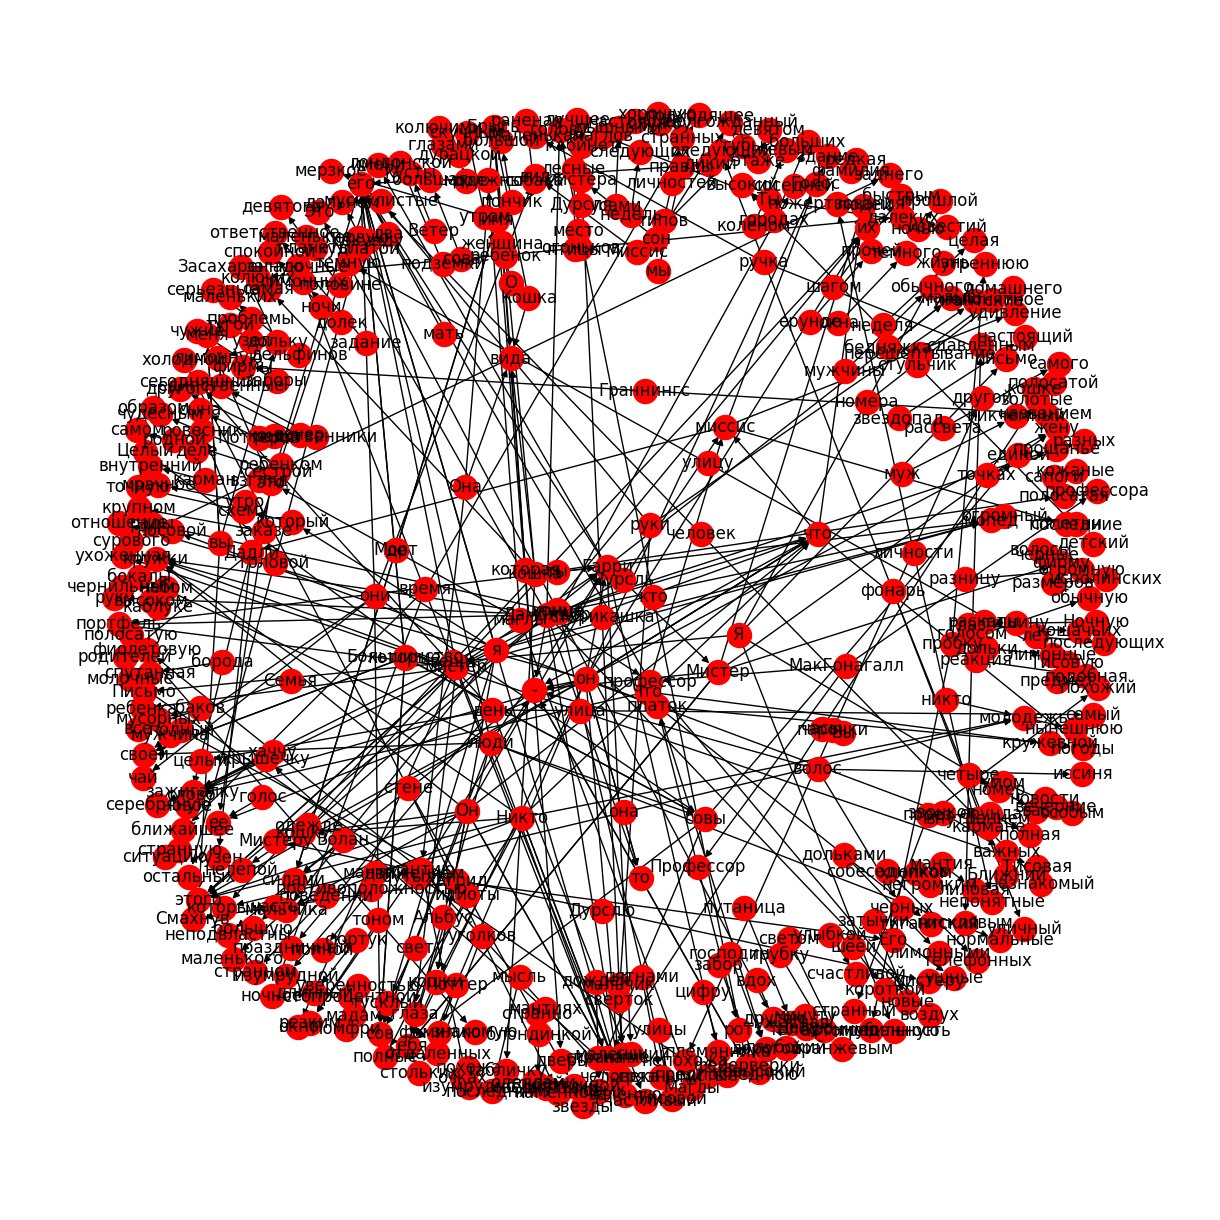

In [ ]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='red', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

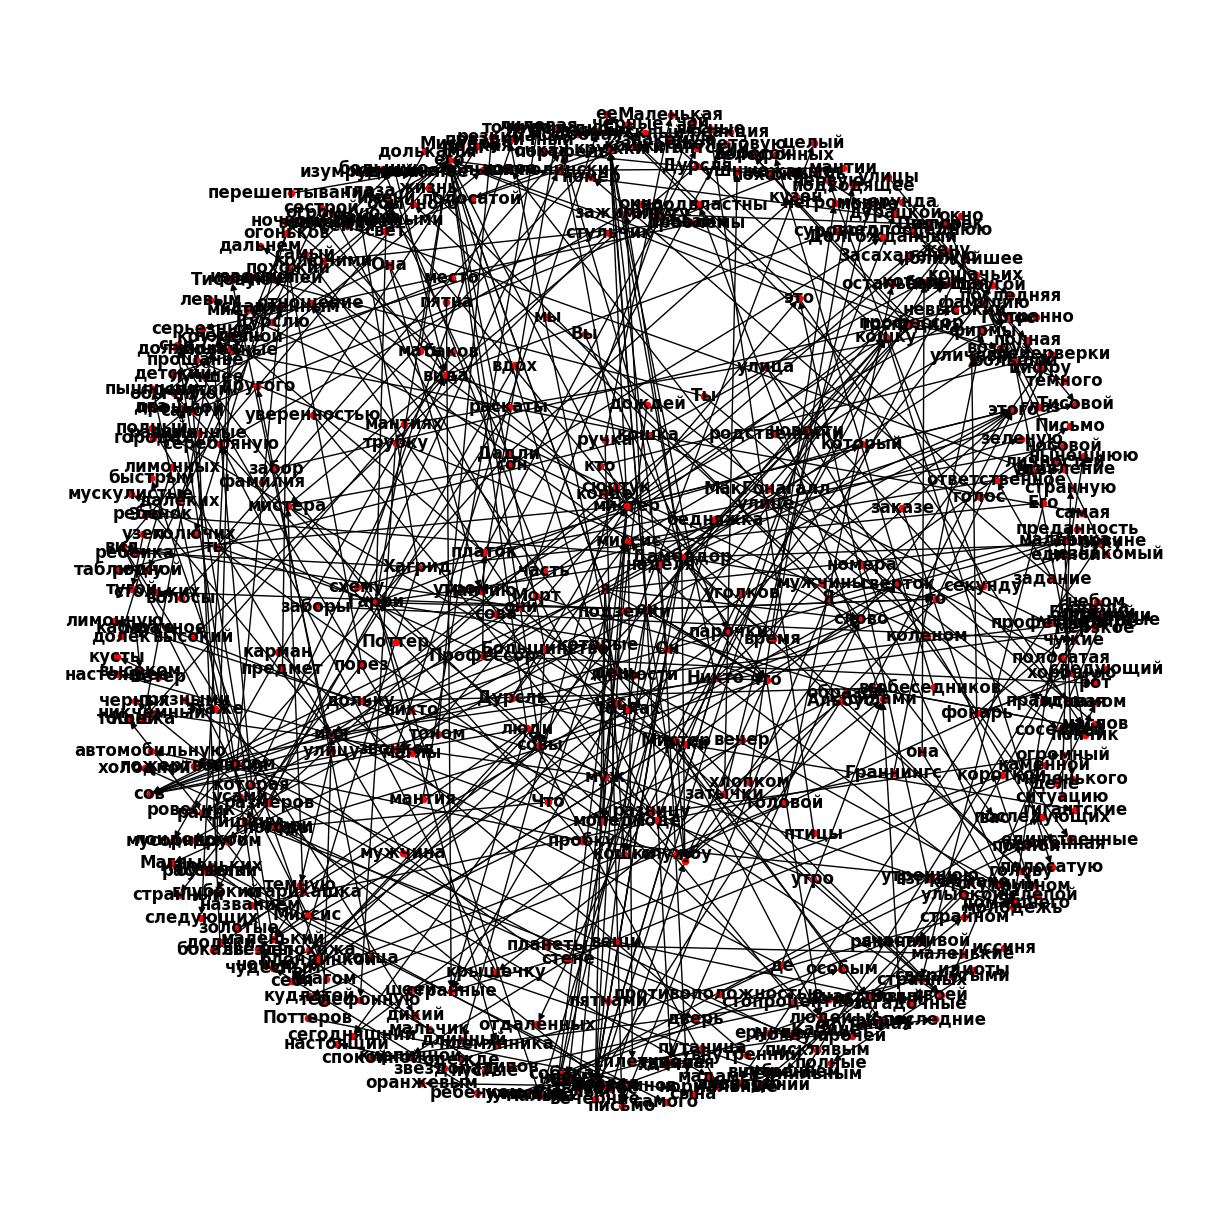

In [ ]:
G=nx.from_pandas_edgelist(kg_df.loc[((kg_df['edge'] !="есть") | (kg_df['source']!="что") | (kg_df['source']!="Что"))], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='red', node_size=20, edge_cmap=plt.cm.Blues, pos = pos, font_weight='bold')
plt.show()